In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [122]:
def load_counts():
    df = pd.read_csv("tpm.csv.gz", index_col=0)
    df = df.iloc[:, 3:]
    counts = df.to_numpy()
    genes = df.index.to_numpy()
    samples = df.columns.to_numpy()
    return counts.T, samples, genes

In [123]:
def get_sample_to_lab_map():
    metadata_df = pd.read_csv(
        "/data/yosef3/users/ruchir/pgp_uq/data/E-GEUV-1.sdrf.txt", sep="\t", index_col=0
    )
    return metadata_df["Performer"].to_dict()


def get_sample_to_sex_map():
    metadata_df = pd.read_csv(
        "/data/yosef3/users/ruchir/pgp_uq/data/E-GEUV-1.sdrf.txt", sep="\t", index_col=0
    )
    return metadata_df["Characteristics[sex]"].to_dict()

In [124]:
def run_umap(counts: np.ndarray):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(counts)
    return embedding


def plot_embedding_by_key(
    embedding: np.ndarray,
    samples: np.ndarray,
    sample_to_key_map: np.ndarray,
    key_name: str,
):
    assert embedding.shape == (len(samples), 2)
    keys = [sample_to_key_map[sample] for sample in samples]

    df = pd.DataFrame({"x": embedding[:, 0], "y": embedding[:, 1], key_name: keys})
    sns.scatterplot(data=df, x="x", y="y", hue=key_name, palette="tab10")
    plt.show()

In [125]:
def plot_pca_variance_explained(
    counts: np.ndarray,
):
    scaler = StandardScaler()
    counts_std = scaler.fit_transform(counts)

    pca = PCA()
    pca.fit(counts_std)
    x = np.arange(1, len(pca.explained_variance_ratio_) + 1)
    y = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(x, y)
    plt.axvline(x=10, color="red")
    plt.xlabel("number of components")
    plt.ylabel("cumulative explained variance")
    plt.show()


def regress_out_n_pcs(counts: np.ndarray, n_pcs: int = 10):
    scaler = StandardScaler()
    counts_std = scaler.fit_transform(counts)

    pca = PCA(n_components=n_pcs)
    counts_pca = pca.fit_transform(counts_std)
    counts_pca_regressed = counts_std - counts_pca @ pca.components_
    counts_regressed = scaler.inverse_transform(counts_pca_regressed)
    return counts_regressed

In [126]:
counts, samples, genes = load_counts()
sample_to_lab_map = get_sample_to_lab_map()
sample_to_sex_map = get_sample_to_sex_map()

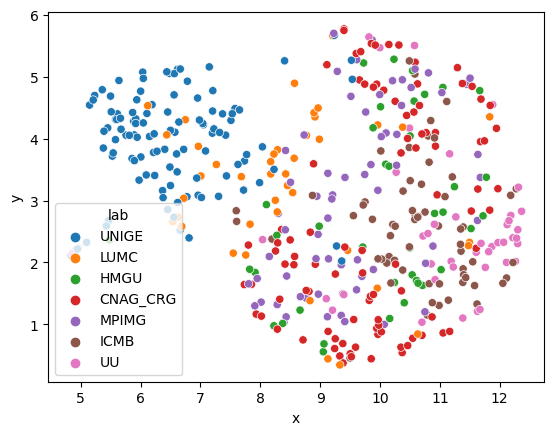

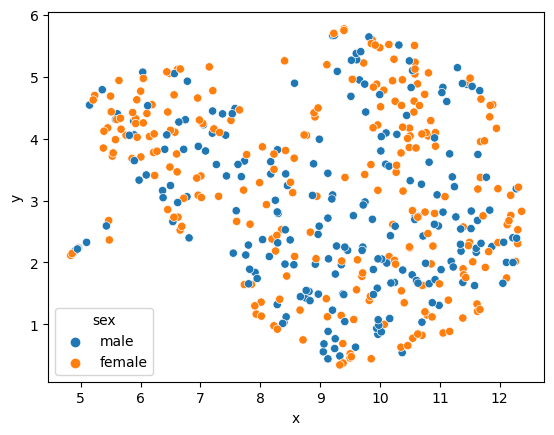

In [127]:
umap_embedding = run_umap(counts)
plot_embedding_by_key(umap_embedding, samples, sample_to_lab_map, "lab")
plot_embedding_by_key(umap_embedding, samples, sample_to_sex_map, "sex")

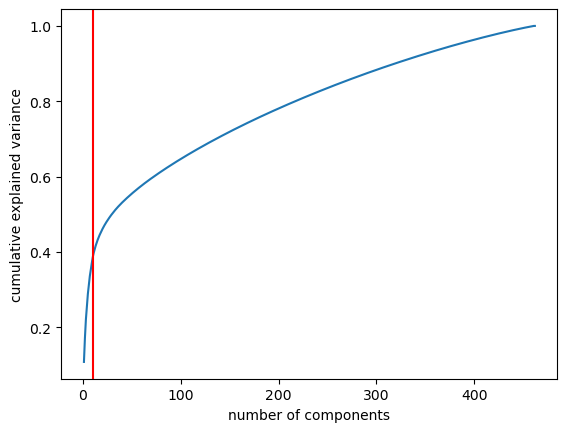

In [128]:
plot_pca_variance_explained(counts)

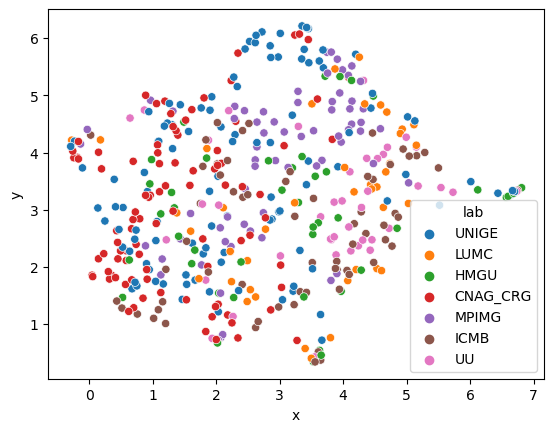

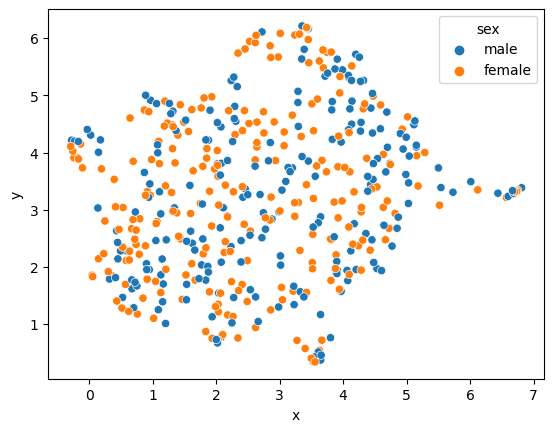

In [129]:
counts_regressed = regress_out_n_pcs(counts, n_pcs=10)
umap_embedding = run_umap(counts_regressed)
plot_embedding_by_key(umap_embedding, samples, sample_to_lab_map, "lab")
plot_embedding_by_key(umap_embedding, samples, sample_to_sex_map, "sex")

<Axes: ylabel='Count'>

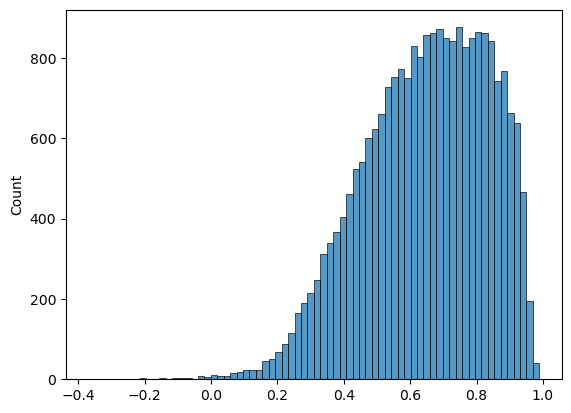

In [130]:
# Plot correlation between counts and counts_regressed
spearmans = [
    spearmanr(counts[:, i], counts_regressed[:, i])[0] for i in range(counts.shape[1])
]
sns.histplot(spearmans)

In [131]:
# RPKM normalized
rpkm_normalized_df = pd.read_csv(
    "/data/yosef3/scratch/ruchir/data/geuvadis/analysis_results/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz",
    sep="\t",
    index_col=0,
)
rpkm_normalized_df = rpkm_normalized_df.iloc[:, 3:]
rpkm_normalized_df = rpkm_normalized_df.loc[genes, samples]
assert rpkm_normalized_df.index.equals(pd.Index(genes))
assert rpkm_normalized_df.columns.equals(pd.Index(samples))
rpkm_normalized = rpkm_normalized_df.to_numpy().T

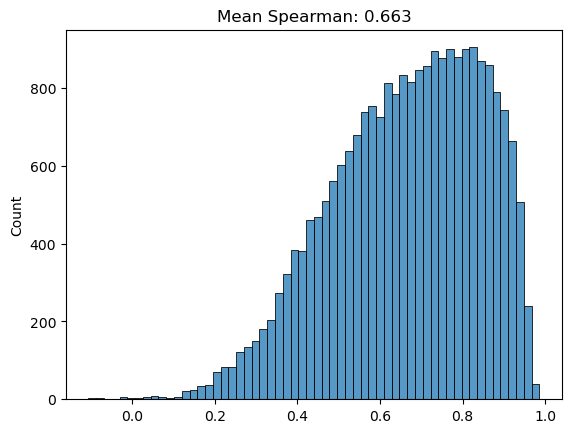

In [132]:
# Plot correlation between RPKM normalized and counts
spearmans = [
    spearmanr(rpkm_normalized[:, i], counts[:, i])[0] for i in range(counts.shape[1])
]
ax = sns.histplot(spearmans)
ax.set_title("Mean Spearman: {:.3f}".format(np.mean(spearmans)))
plt.show()

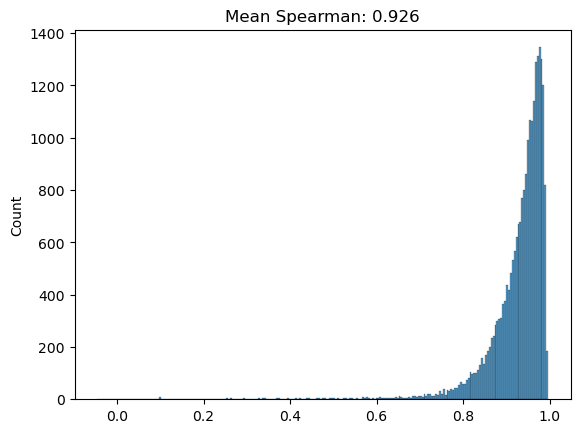

In [133]:
# Plot correlation between RPKM normalized and counts_regressed
spearmans = [
    spearmanr(rpkm_normalized[:, i], counts_regressed[:, i])[0]
    for i in range(counts_regressed.shape[1])
]
ax = sns.histplot(spearmans)
ax.set_title("Mean Spearman: {:.3f}".format(np.mean(spearmans)))
plt.show()

In [134]:
def create_tpm_normalized_df(
    counts_regressed: np.ndarray, samples: np.ndarray, genes: np.ndarray
):
    df = pd.read_csv("tpm.csv", index_col=0)
    assert df.index.equals(pd.Index(genes))
    assert df.columns[3:].equals(pd.Index(samples))
    df.iloc[:, 3:] = counts_regressed.T
    return df

In [135]:
tpm_normalized_df = create_tpm_normalized_df(counts_regressed, samples, genes)

In [136]:
tpm_normalized_df.to_csv("tpm_pca.csv.gz")